In [3]:
#Dwave imports
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import dimod

#Impots for QUBO probelm
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib as plt
import itertools
from itertools import product
from matplotlib import pyplot as plt


Generate all of the possible lines from cart coords, currently doesnt encode vertical lines. And the QUBO matrix. There are two version of the QUBO matrix, the first penalises acceptable skew lines and the latter is a minor improvment. Details in the notebook.

In [7]:
#Find all fo the lines to optimise over
def get_skew_lines(n):
    #Get list of cart coords
    xs = np.linspace(0,n,n,endpoint = False)
    ys = np.linspace(0,n,n,endpoint = False)
    X = product(xs,ys)
    X = np.array(list(X))
    #dx,dy,y_intercept

    lines = []
    for k in range(X.shape[0]):
        for d in range(k,X.shape[0]):
            if X[k][0]-X[d][0] != 0 and X[k][1]-X[d][1] != 0:
                grad = (X[k][1]-X[d][1])/(X[k][0]-X[d][0])
                y_intercept = X[k][1] - grad * X[k][0]
                line = (grad,y_intercept)
                lines.append(line)
    lines = np.array(lines)
    return lines

#Check if a point is on a line (l belongs to delta_l)
def delta_l(i,j,a,b,n):
    if np.round(j - a*i - b, 1) == 0 and i < n and j < n:
        return True
    else: 
        return False


def get_Q(n,lines,alpha,beta,gamma,omega):
    Q = np.zeros((n**2,n**2))
    rows = np.linspace(0,n,n,endpoint = False, dtype = 'int32')
    cols = np.linspace(0,n,n,endpoint = False, dtype = 'int32')

#1
    for i in cols:
        for j in rows:
            for s in rows:
                Q[int(i*n+j),int(i*n+s)] += alpha
#2
    for j in rows:
        for i in cols:
            for r in cols:
                Q[int(i*n+j),int(r*n+j)] += beta
#3
    for l in lines:
        a = l[0]
        b = l[1]
        for i in cols:
            for j in rows:
                for r in cols:
                    for s in rows:
                        if delta_l(i,j,a,b,n) & delta_l(r,s,a,b,n):
                            Q[int(i*n+j),int(r*n+s)] += gamma
#4
    for i in rows:
        for j in cols:
            Q[int(i*n+j),int(i*n+j)] -=4*(alpha + beta)
#5
    for l in lines:
        a = l[0]
        b = l[1]
        for i in cols:
            for j in rows:
                if delta_l(i,j,a,b,n):
                    Q[int(i*n+j),int(i*n+j)] -= 4*gamma
#6
    for i in cols:
        for j in rows:
            Q[int(i*n+j),int(i*n+j)] -= 4 * n
            for r in cols:
                for s in rows:
                    Q[int(i*n+j),int(r*n+s)] += omega
    return Q



def get_Q_rev(n,lines,alpha,beta,gamma,omega):

    Q = np.zeros((n**2,n**2))
    rows = np.linspace(0,n,n,endpoint = False, dtype = 'int32')
    cols = np.linspace(0,n,n,endpoint = False, dtype = 'int32')


    #Vertical lines
    for i in cols:
        for j in rows:
            Q[i*n+j,i*n+j] -= 4*alpha
            for s in rows:
                Q[i*n+j,i*n+s] += alpha

    
    #Horizontal lines:
    for j in rows:
        for i in cols:
            Q[i*n+j,i*n+j] -= 4*beta
            for r in cols:
                Q[i*n+j,r*n+j] += beta

    #Skew lines
    for l in lines:
        a = l[0]
        b = l[0]
        for i in cols:
            for i in rows:
                if delta_l(i,j,a,b,n):
                    Q[i*n+j,i*n+j] -= 7*gamma
                for r in cols:
                    for s in rows:
                        if delta_l(i,j,a,b,n) and delta_l(r,s,a,b,n):
                            Q[i*n+j,r*n+s] += 3 * gamma
    return Q






The above function generates the QUBO matrix, details in my notebook.

In [102]:
def get_lowest_eval(Q):
    w,v = LA.eig(Q)
    g = v[np.argmin(w)]
    print('The lowest energy is' , w[np.argmin(w)])
    return g

In [ ]:
def get_bin_list(n):
    bin_list = np.array(list(map(list, itertools.product([0, 1], repeat=n**2))))[1:]
    return bin_list

bin_list = get_bin_list(n)

In [ ]:
bin_list.shape

In [ ]:
np.savetxt('binary_string',bin_list,delimiter = ',') #run later

In [ ]:
def get_lowest_bitstring(bin_list,Q):
    energies = []
    for i in range(bin_list.shape[0]):
        E = bin_list[i].T @ Q @ bin_list[i]
        energies.append(E)
    b = bin_list[np.argmin(energies)]
    print('The lowest energy is' , energies[np.argmin(energies)])
    return b,energies

In [31]:
def make_img_bit_string(b):
    plt.imshow(b.reshape((n,n)))
    plt.show()
    print(b)

In [ ]:
n = 5
lines = np.unique(get_skew_lines(n),axis = 0)
Q_1 = get_Q(n,lines,1,1,1,1)
Q_1_rev= get_Q_rev(n,lines,1,1,1,1)

Q_2 = get_Q(n,lines,2,2,1,1)
Q_2_rev = get_Q_rev(n,lines,2,2,1,1)

Q_3 = get_Q(n,lines,1,1,5,1)
Q_3_rev = get_Q_rev(n,lines,1,1,5,1)


In [ ]:
ground_string_1,energies_1 = get_lowest_bitstring(bin_list,Q_1)
ground_string_1_rev,energies_1_rev = get_lowest_bitstring(bin_list,Q_1_rev)
make_img_bit_string(ground_string_1)
make_img_bit_string(ground_string_1_rev)


In [ ]:
ground_string_2,energies_2 = get_lowest_bitstring(bin_list,Q_2)
ground_string_2_rev,energies_2_rev = get_lowest_bitstring(bin_list,Q_2_rev)
make_img_bit_string(ground_string_2)
make_img_bit_string(ground_string_2_rev)

In [ ]:
ground_string_3,energies_3 = get_lowest_bitstring(bin_list,Q_3)
ground_string_3_rev,energies_3_rev = get_lowest_bitstring(bin_list,Q_3_rev)
make_img_bit_string(ground_string_3)
make_img_bit_string(ground_string_3_rev)

Dwave quantum annealer, set inderactions to be the off-diagonal elements of the QUBO matrix Q. Set the diagonal elements to be the activation weights.

In [ ]:
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel

n = 5

#define binary decision vector.
x = [f's_{i}' for i in range(n**2)]

bqm = BinaryQuadraticModel('BINARY')

for d in range(n**2):
    bqm.add_variable(x[int(d)],Q[int(d),int(d)])
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        if i != j:
            bqm.add_interaction(x[int(i)],x[int(j)],Q[i,j])


sols = []
for i in range(10):
    sampler = EmbeddingComposite(DWaveSampler())
    sampletest = sampler.sample(bqm, num_reads = 5000)
    solution = np.array(list(sampletest.first.sample.values()))
    energy = sampletest.first.energy
    sols.append((solution,energy))
    make_img_bit_string(solution)

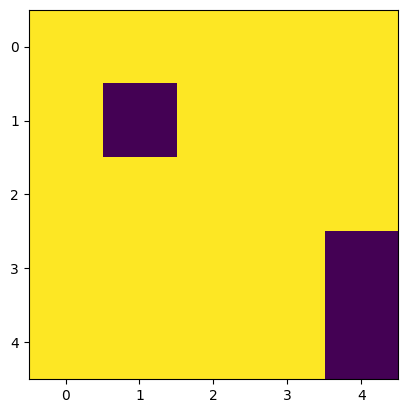

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0]


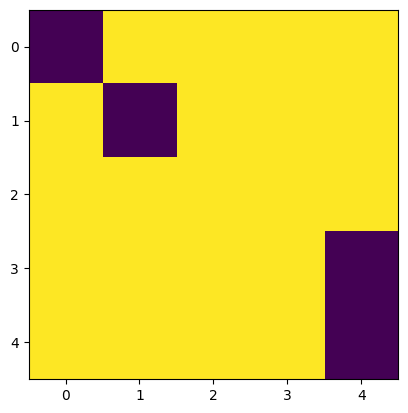

[0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0]


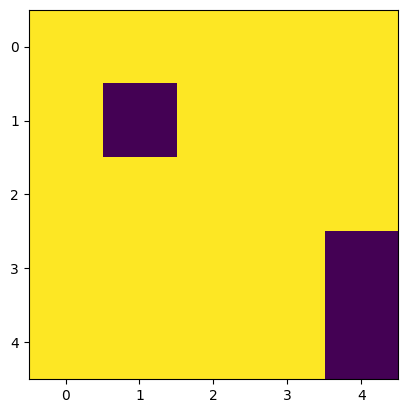

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0]


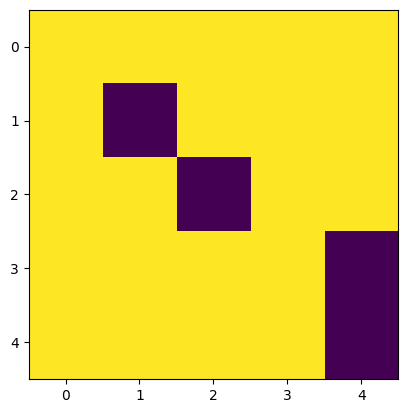

[1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0]


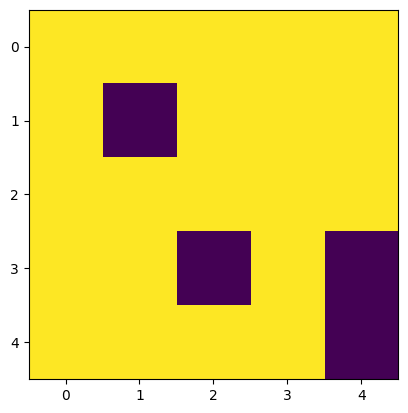

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0]


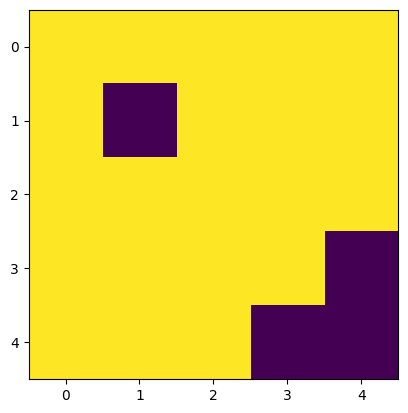

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0]


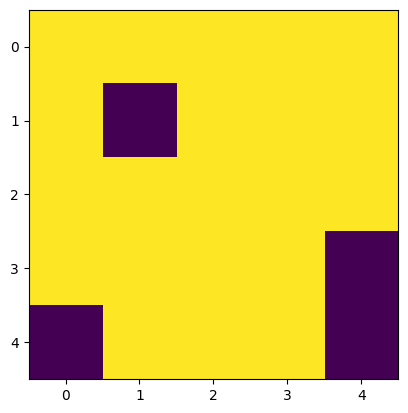

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]


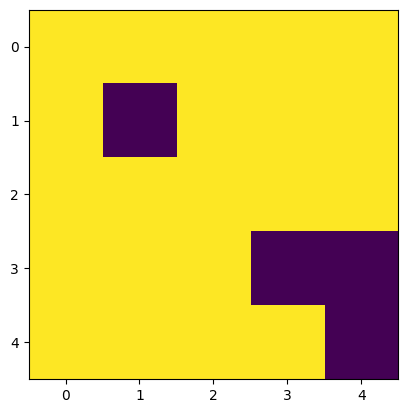

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0]


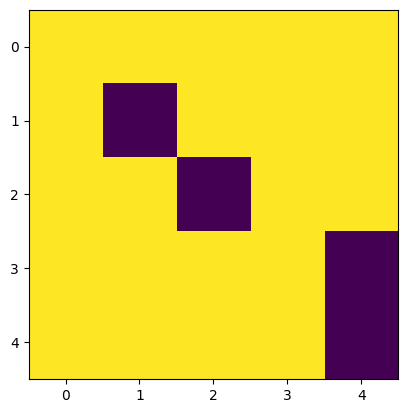

[1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0]


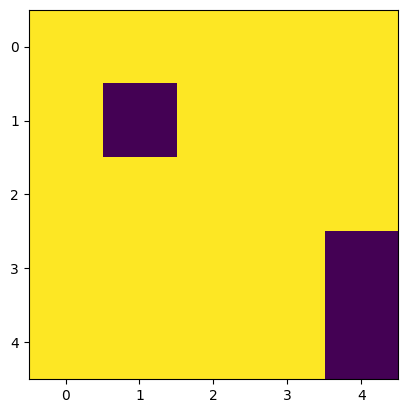

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0]


In [9]:
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel

n = 5
lines = np.unique(get_skew_lines(n),axis = 0)

Q = get_Q_rev(n,lines,-1,-1,-1,1)
#define binary decision vector.
x = [f's_{i}' for i in range(n**2)]

bqm = BinaryQuadraticModel('BINARY')

for d in range(n**2):
    bqm.add_variable(x[int(d)],Q[int(d),int(d)])
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        if i != j:
            bqm.add_interaction(x[int(i)],x[int(j)],Q[i,j])

sols = []
for i in range(10):
    sampler = EmbeddingComposite(DWaveSampler())
    sampletest = sampler.sample(bqm, num_reads = 5000)
    solution = np.array(list(sampletest.first.sample.values()))
    energy = sampletest.first.energy
    sols.append((solution,energy))
    make_img_bit_string(solution)

In [ ]:
make_img_bit_string(solution)

# Discrete binary model encoding

In [125]:
def make_img_dis(b):
    s = np.zeros((n,n))
    for i in range(n):
            s[i,b[i]] = 1
            s[i,b[i+n]] = 1 

    plt.imshow(s)
    plt.show()

In [153]:
#Usfull spaces:
n = 4

N_3 = [perm for perm in itertools.permutations(range(n),3)]
N3 = [prod for prod in itertools.product(range(n), repeat =  3)]
N6 = [prod for prod in itertools.product(range(n), repeat =  6)]
N_6 = [perm for perm in itertools.permutations(range(n),6)]
B = [binary for binary in itertools.product([0, 1], repeat = 3)]
N2 = [prod for prod in itertools.product(range(n), repeat = 2)]


In [154]:
## Linear attempt
X_lin = np.zeros((2*n,n))
for i,j,k in N_3:
    for s,r,t in B:
        for u in range(n):
            if i > j and j > k:
                X_lin[k + n*t,u] -= (j - i)*u
                X_lin[j + r*n,u] -= (i - k)*u
                X_lin[i + s*n,u] -= (k - j)*u

In [155]:
#Add linear costs:
dqm = dimod.DiscreteQuadraticModel()
dis_vars = []
for i in range(2*n):
    dis_vars.append(dqm.add_variable(n))
    for case in range(n):
        dqm.set_linear_case(dis_vars[i],case,X_lin[i,case])

from dwave.system import LeapHybridDQMSampler
dqm_sampler = LeapHybridDQMSampler()
sampleset = dqm_sampler.sample_dqm(dqm) 
df =  sampleset.to_pandas_dataframe().drop_duplicates()


In [156]:
sampleset

SampleSet(rec.array([([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 2, 3, 0], -176., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 0, 0, 3, 3, 0], -192., 1),
           ([0, 3, 3, 1, 0, 3, 3, 0], -176., 1),
           ([0, 3, 3, 0, 0, 3, 2, 0], -176., 1),
           ([1, 2, 3, 0, 0, 3, 3, 0], -160., 1),
          

In [157]:
df 

,0,1,2,3,4,5,6,7,energy,num_occurrences
0,0,3,3,0,0,3,3,0,-192.0,1
14,0,3,3,0,0,2,3,0,-176.0,1
17,0,3,3,1,0,3,3,0,-176.0,1
18,0,3,3,0,0,3,2,0,-176.0,1
19,1,2,3,0,0,3,3,0,-160.0,1
24,0,3,1,0,0,3,3,0,-160.0,1


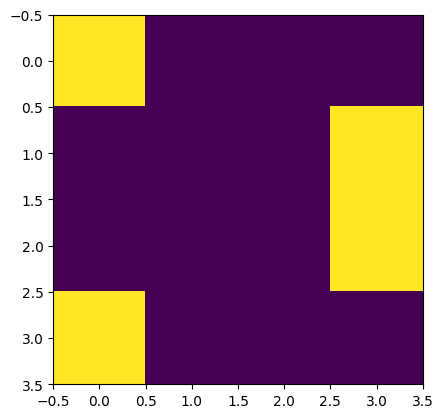

0    0.0
1    3.0
2    3.0
3    0.0
4    0.0
5    3.0
6    3.0
7    0.0
Name: 0, dtype: float64


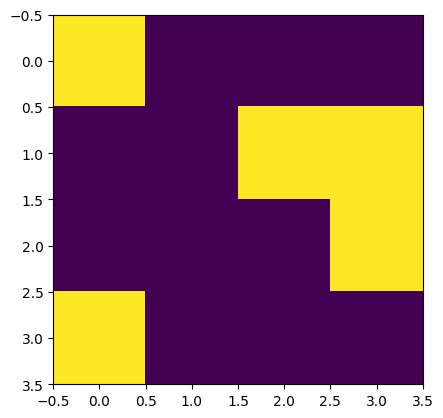

0    0.0
1    3.0
2    3.0
3    0.0
4    0.0
5    2.0
6    3.0
7    0.0
Name: 14, dtype: float64


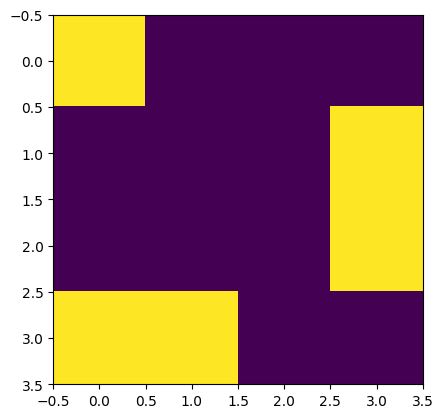

0    0.0
1    3.0
2    3.0
3    1.0
4    0.0
5    3.0
6    3.0
7    0.0
Name: 17, dtype: float64


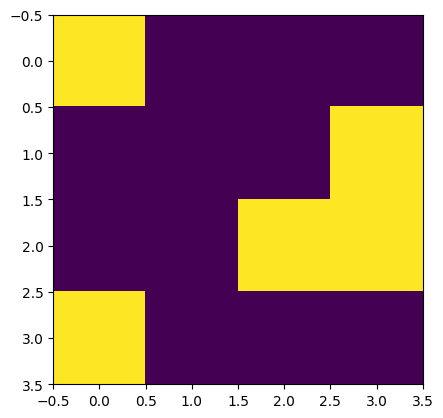

0    0.0
1    3.0
2    3.0
3    0.0
4    0.0
5    3.0
6    2.0
7    0.0
Name: 18, dtype: float64


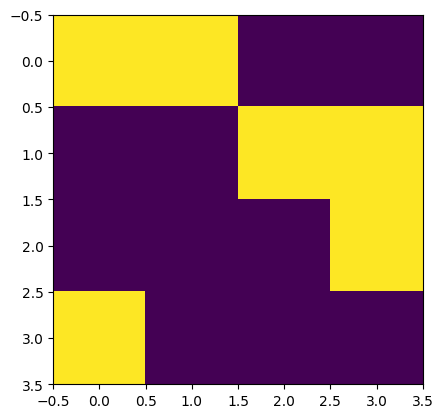

0    1.0
1    2.0
2    3.0
3    0.0
4    0.0
5    3.0
6    3.0
7    0.0
Name: 19, dtype: float64


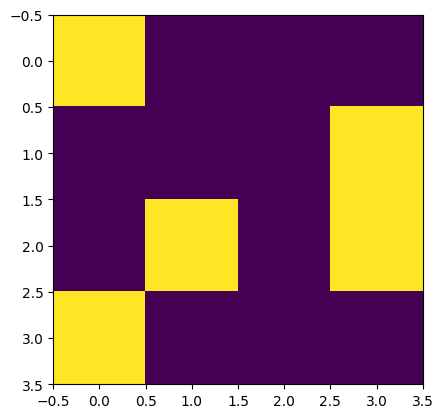

0    0.0
1    3.0
2    1.0
3    0.0
4    0.0
5    3.0
6    3.0
7    0.0
Name: 24, dtype: float64


In [158]:
for i in range(df.shape[0]):
    make_img_dis(np.array(df.iloc[i,:2*n],dtype = 'int32'))
    print(df.iloc[i,:2*n])

In [ ]:
### NON linear attempt

In [92]:
#Linear weight matrix
#X_L[i,u] = ai,u
X_L = np.zeros((2*n,n))
for i,j,k in N_3:
    for s,r,t in B:
        for u1,u2,u3 in N3:
             if (u1 != u2 or u2 != u3):
                X_L[s*n + i,u1] -= ((k - j)**2) * u1**2
                X_L[r*n + j,u2] -= ((i - k)**2) * u2**2
                X_L[t*n + k,u3] -= ((j - i)**2) * u3**2


#X_Q[i,j,u,v] := ai,u * aj,v
X_Q = np.zeros((2*n,2*n,n,n))
for i,j,k in N_3:
    for s,r,t in B:
        for u1,u2,u3,v1,v2,v3 in N6:
            if (u1 != u2 or u2 != u3) and (v1 != v2 or v2 != v3) and (u1 != v2) and (u1!=v3) and (u2 != v1) and (u2 != v3) and (u3 != v1) and (u3 != v2):
                X_Q[s*n + i,r*n + j][u1,v1] -= 2*(k - j)*(i - k)*u1*v1
                X_Q[s*n + i,t*n + k][u2,v2] -= 2*(k - j)*(j - i)*u2*v2
                X_Q[r*n + j,t*n + k][u3,v3] -= 2*(i - k)*(j - i)*u3*v3
               # print(2*(k - j)*(i - k)*u1*v1,2*(k - j)*(j - i)*u2*v2,2*(i - k)*(j - i)*u3*v3)

In [93]:
X_Q[2,1],X_Q[3,1]

(array([[     0.,      0.,      0.,      0.,      0.],
        [     0.,  17280.,  33120.,  49680.,  66240.],
        [     0.,  33120.,  69120.,  99360., 132480.],
        [     0.,  49680.,  99360., 155520., 198720.],
        [     0.,  66240., 132480., 198720., 276480.]]),
 array([[     0.,      0.,      0.,      0.,      0.],
        [     0.,   8640.,  16560.,  24840.,  33120.],
        [     0.,  16560.,  34560.,  49680.,  66240.],
        [     0.,  24840.,  49680.,  77760.,  99360.],
        [     0.,  33120.,  66240.,  99360., 138240.]]))

In [97]:
#Add linear costs:
dqm = dimod.DiscreteQuadraticModel()
dis_vars = []
for i in range(2*n):
    dis_vars.append(dqm.add_variable(n))
    for case in range(n):
        dqm.set_linear_case(dis_vars[i],case,X_L[i,case])


#Add quadratic costs:
for a,b in [prod for prod in itertools.product(range(2*n), repeat = 2)]:
    for u,v in [cases for cases in itertools.product(range(n), repeat = 2)]:
        if a != b:
            dqm.set_quadratic(dis_vars[a],dis_vars[b], {(u,v) : X_Q[a,b][u,v]})



In [140]:
from dwave.system import LeapHybridDQMSampler
dqm_sampler = LeapHybridDQMSampler()
sampleset = dqm_sampler.sample_dqm(dqm)  
df_NL = sampletest.to_pandas_dataframe().drop_duplicates()

In [143]:
sampletest

SampleSet(rec.array([([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], -201., 2, 0.  ),
           ([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0], -197., 2, 0.  ),
           ([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], -193., 1, 0.  ),
           ...,
           ([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0], -143., 1, 0.04),
           ([1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0], -141., 1, 0.04),
           ([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],  -44., 1, 0.04)],
          dtype=[('sample', 'i1', (25,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')]), Variables(['s_0', 's_1', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_2', 's_20', 's_21', 's_22', 's_23', 's_24', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9']), {'timing':

In [141]:
df_NL

,s_0,s_1,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,...,s_3,s_4,s_5,s_6,s_7,s_8,s_9,chain_break_fraction,energy,num_occurrences
0,1,1,1,1,1,1,0,1,1,1,...,1,0,1,1,1,1,0,0.00,-201.0,2
1,1,1,1,1,1,1,0,1,1,1,...,1,0,1,1,1,1,0,0.00,-197.0,2
2,1,1,0,1,1,1,0,1,1,1,...,1,0,1,1,1,1,0,0.00,-193.0,1
3,1,1,1,1,1,1,0,1,1,1,...,1,0,1,0,1,1,0,0.00,-193.0,2
4,1,1,1,0,1,1,0,1,1,1,...,1,0,1,1,1,1,0,0.00,-193.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4850,0,1,1,1,0,1,0,0,1,0,...,0,0,1,1,1,1,0,0.04,-153.0,1
4851,1,1,1,1,0,1,0,0,1,0,...,1,0,1,0,1,1,0,0.08,-155.0,1
4852,0,1,0,1,1,1,0,0,1,0,...,1,0,0,0,1,0,0,0.04,-143.0,1
4853,1,1,0,0,1,1,0,1,0,0,...,0,0,0,1,1,1,0,0.04,-141.0,1


In [144]:
for i in range(df.shape[0]):
    make_img_bit_string(np.array(df_NL.iloc[i,:2*n],dtype = 'int32'))
    print(df_NL.iloc[i,:2*n])

ValueError: cannot reshape array of size 8 into shape (4,4)